##  <font color='red'> Model 1: Audio recognition using 1D Convolutional Neural Network </font>

In [1]:
import matplotlib.pyplot as plt 
from scipy import signal 
from scipy.io import wavfile 
import os 
import IPython.display as ipd
import math as mt 
import librosa 
from librosa.display import waveplot
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow 
import numpy as np

%matplotlib inline 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Total number of classes:  12

'backward',
'forward',
'yes'
'no',
'on',
'off',
'up',
'down',
'stop',
'happy',
'silence',
'unknown'
##### The model will predict "zero" and "nine" as unknown

In [2]:
train_audio_path = 'audio_data/Audio_8hz/'

In [3]:
labels=os.listdir(train_audio_path)
labels

['backward',
 'happy',
 'silence',
 'no',
 'nine',
 'stop',
 'zero',
 'up',
 'down',
 'yes',
 'on',
 'forward',
 'off']

In [4]:
labels_to_consider = [
 'backward',
 'down',
 'forward',
 'happy',
 'no',
 'on',
 'off',
 'silence',
 'stop',
 'up',
 'yes']

### Loading the data and assigning unknown category to zero and nine

#### Ignoring audio files with length less than 1 sec

In [5]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 8000)
        if(len(samples)== 8000): 
            all_wave.append(samples)
            if label in labels_to_consider:
                all_label.append(label)
            else:
                all_label.append('unknown')

backward
happy
silence
no
nine
stop
zero
up
down
yes
on
forward
off


#### Convert the output labels to integer encoded:

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

#### Final list of classes

In [7]:
classes

['backward',
 'down',
 'forward',
 'happy',
 'no',
 'off',
 'on',
 'silence',
 'stop',
 'unknown',
 'up',
 'yes']

### Check the baseline using majority classification rule:
#### The majority class in this model is "unknown" with the 19.2% of audio files. So, the baseline of this model is 19.2%

In [8]:
count_unknown = 0
train_audio_path = 'audio_data/Audio_8hz/'
labels=os.listdir(train_audio_path)
total_count = 0
for label in labels:
    total_count = total_count + len(os.listdir(train_audio_path+label))
for label in labels:
    if label == 'zero' or label == 'nine':
        count = len(os.listdir(train_audio_path+label))
        count_unknown = count_unknown + count
    else:
        count = len(os.listdir(train_audio_path+label))
        print(label+'\t'+str(round(count/total_count*100,1))+'%')
print('unknown' +'\t'+str(round(count_unknown/total_count*100,1))+'%')

backward	4.0%
happy	4.9%
silence	2.7%
no	9.5%
stop	9.3%
up	8.9%
down	9.4%
yes	9.7%
on	9.2%
forward	4.1%
off	9.0%
unknown	19.2%


#### Convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [9]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(classes))

Using TensorFlow backend.


#### Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [10]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

#### Split into train and validation set
Next, we will train the model on 80% of the data and validate on the remaining 20%:

In [11]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [41]:
x_tr.shape

(30367, 8000, 1)

### Model building
Let us implement the model using Keras functional API.

In [16]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow 


inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(32,13, padding='same', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(32, 11, padding='same', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(64, 9, padding='same', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(128, 7, padding='same', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(1024, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(classes), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 8000, 32)          448       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2666, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2666, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2666, 32)          11296     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 888, 32)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 888, 32)           0   

#### Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#### Early stopping is the callbacks to stop training the neural network at the right time 

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001) 

#### Train the model on 50 epochs and batch size of 32

In [19]:
history=model.fit(x_tr, y_tr ,epochs=50, callbacks=[es], batch_size=32, validation_data=(x_val,y_val))

Train on 30367 samples, validate on 7592 samples
Epoch 1/50
30367/30367 [==============================] - 585s 19ms/sample - loss: 1.4626 - accuracy: 0.4886 - val_loss: 0.7516 - val_accuracy: 0.7513
Epoch 2/50
30367/30367 [==============================] - 602s 20ms/sample - loss: 0.7879 - accuracy: 0.7333 - val_loss: 0.5844 - val_accuracy: 0.8093
Epoch 3/50
30367/30367 [==============================] - 582s 19ms/sample - loss: 0.6171 - accuracy: 0.7934 - val_loss: 0.5517 - val_accuracy: 0.8238
Epoch 4/50
30367/30367 [==============================] - 577s 19ms/sample - loss: 0.5266 - accuracy: 0.8267 - val_loss: 0.5019 - val_accuracy: 0.8356
Epoch 5/50
30367/30367 [==============================] - 557s 18ms/sample - loss: 0.4503 - accuracy: 0.8489 - val_loss: 0.4265 - val_accuracy: 0.8645
Epoch 6/50
30367/30367 [==============================] - 557s 18ms/sample - loss: 0.4037 - accuracy: 0.8649 - val_loss: 0.4001 - val_accuracy: 0.8712
Epoch 7/50
30367/30367 [=====================

### Save the model

In [43]:
model.save('conv1D_model.h5')

### Maximum model accuracy

In [21]:
print("Maximum accuracy of model is: ", max(history.history['accuracy']))

Maximum accuracy of model is:  0.93776137


### Maximum validation accuracy

In [22]:
print("Maximum validation accuracy of model is: ", max(history.history['val_accuracy']))

Maximum validation accuracy of model is:  0.9010801


### Plot the results

### Visualize the validation and training loss

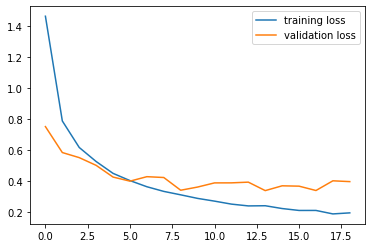

In [24]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='training loss')
pyplot.plot(history.history['val_loss'], label='validation loss')
pyplot.legend()
pyplot.show()

### Visualize the validation and trainig accuracy

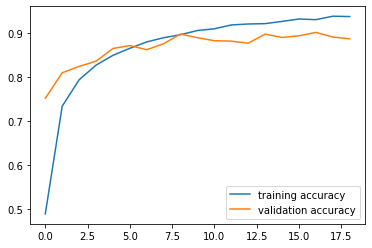

In [25]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='training accuracy')
pyplot.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

### Predictions:
Define the function that predicts text for the given audio:

In [26]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

### Make the predictions on validation data

In [27]:
import random
for i in range(10):
    index=random.randint(0,len(x_val)-1)
    samples=x_val[index].ravel()
    print("\nAudio:",classes[np.argmax(y_val[index])])
    ipd.Audio(samples, rate=8000)
    print("Text:",predict(samples))


Audio: yes
Text: yes

Audio: yes
Text: yes

Audio: unknown
Text: unknown

Audio: up
Text: up

Audio: no
Text: no

Audio: happy
Text: happy

Audio: no
Text: no

Audio: down
Text: stop

Audio: stop
Text: stop

Audio: no
Text: no


### Generate a confusion matrix

In [28]:
y_pred = model.predict(x_val)

In [29]:
y_pred_again = []
for i in range(len(y_pred)):
    r = np.zeros(12)
    r[np.argmax(y_pred[i])] = 1
    y_pred_again.append(r)


In [30]:
yyyyy = np.array(y_pred_again)

In [31]:
y_pred.shape

(7592, 12)

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val.argmax(axis=1), yyyyy.argmax(axis=1))

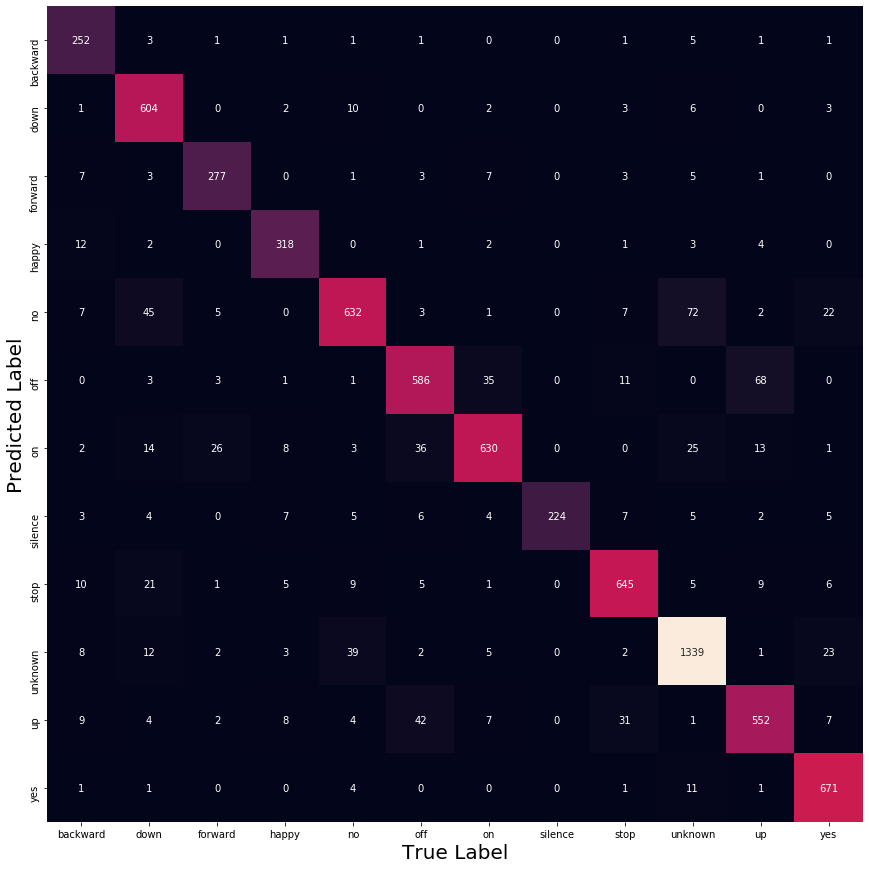

In [33]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('True Label', fontsize = 20)
plt.ylabel('Predicted Label', fontsize = 20);

### Classification Report

In [35]:
from sklearn.metrics import classification_report

y_true = y_val.argmax(axis=1)
y_pred = model.predict(x_val)

y_pred_again = []
for i in range(len(y_pred)):
    r = np.zeros(12)
    r[np.argmax(y_pred[i])] = 1
    y_pred_again.append(r)
    
yyyyy = np.array(y_pred_again)
y_pred = np.argmax(yyyyy, axis=1)
target_names = classes

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(7592,) (7592,)
              precision    recall  f1-score   support

    backward       0.94      0.81      0.87       312
        down       0.96      0.84      0.90       716
     forward       0.90      0.87      0.89       317
       happy       0.93      0.90      0.91       353
          no       0.79      0.89      0.84       709
         off       0.83      0.86      0.84       685
          on       0.83      0.91      0.87       694
     silence       0.82      1.00      0.90       224
        stop       0.90      0.91      0.90       712
     unknown       0.93      0.91      0.92      1477
          up       0.83      0.84      0.84       654
         yes       0.97      0.91      0.94       739

    accuracy                           0.89      7592
   macro avg       0.89      0.89      0.88      7592
weighted avg       0.89      0.89      0.89      7592

